# Create path to images
### Path can be in google drive or local path

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
base_dir = "drive/My Drive/Colab Notebooks/ALL DATA/animals" # FOR DRIVE
#base_dir = '/home/srikumar/Desktop/'. #UBUNTU
#base_dir = "/Users/sanjay/Desktop/CODE/Python/Animal-Classification/DATA" #MACBOOK
class_names = ['cat', 'lynx', 'wolf', 'coyote', 'cheetah', 'jaguar', 'chimpanzee', 'orangutan', 'hamster', 'guinea pig']
print('[DATA] READ IN ZIP')
date_base = os.path.join(base_dir,'animals')

[DATA] READ IN ZIP


### Splits images by the Categories defined above

In [0]:
import os.path
from os import path
import glob
import shutil
for folder in os.listdir(date_base):
  print(folder)
  if(folder =='.DS_Store'):
    continue
  if not(path.exists(os.path.join(date_base, folder,'sorted'))): #makes sorted folder 
    print('Made sorted in ', folder )
    os.mkdir(os.path.join(date_base, folder,'sorted'))
  #Splits up images into categorized directories
  for image in os.listdir(os.path.join(date_base, folder)):
    if not('_img_' in image):
      continue
    animal = image.split("_img_")[0]
    target_dir = os.path.join(date_base,folder,'sorted',animal)
    if not os.path.isdir(target_dir):
        os.mkdir(target_dir)
    if not path.exists(os.path.join(target_dir, image)): #if image hasnt been copied over
        shutil.copy(os.path.join(date_base,folder,image), os.path.join(target_dir,image))  
print('done!') 


training
testing
done!


# Keras ImageDataGenerator/Images as numpy array

---



In [0]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from keras.preprocessing.image import img_to_array
from imutils import paths
import numpy as np
import os
import cv2
shape = (128,128)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
    os.path.join(date_base, 'training', 'sorted'),
    target_size=shape,
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    os.path.join(date_base, 'testing', 'sorted'),
    target_size=shape,
    batch_size=32,
    class_mode='categorical')
#FOR USE IF NOT USING KERAS IMAGE DATA GENERATOR
'''
#Data in np arrays
data = []
labels = []
print('running1')
imagePaths = sorted(list(paths.list_images(date_base+'/training')))
for imagePath in imagePaths:
	#load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	try:
		image = cv2.resize(image,shape)
		image = img_to_array(image)
		data.append(image)
		# extract the class label from the image path and update the labels list
		label = imagePath.split(os.path.sep)[-1]
		labels.append(label[0]) #strips the number label from the front
	except:
		print('Skipped')
 # scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
x_train, y_train = data, labels

print('finished running1')

#Data in np arrays
data = []
labels = []
print('running2')

imagePaths = sorted(list(paths.list_images(date_base+'/testing')))
for imagePath in imagePaths:
	#load the image, pre-process it, and store it in the data list
  image = cv2.imread(imagePath)
  try:
    image = cv2.resize(image,shape)
    image = img_to_array(image)
    data.append(image)
		# extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-1]
    labels.append(label[0]) #strips the number label from the front
  except:
    print('Skipped')
 # scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
x_test, y_test = data, labels

# Normalizing the input image
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

#Converting labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
'''
print('done')

Using TensorFlow backend.


Found 10993 images belonging to 10 classes.
Found 44006 images belonging to 10 classes.
done


# Models

### VGG19

In [0]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19, VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout
from keras.utils import to_categorical
import tensorflow as tf
import random
shape = (128,128)

#Defining the hyperparameters
batch_size= 100
EPOCHS = 20
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01,  patience=3, min_lr=1e-5)
base_model_VGG19 = VGG19(include_top=False, weights='imagenet', input_shape=(shape[0],shape[1],3), classes= len(class_names))
#y_train.shape[1]
class endTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>=.70 and logs.get('acc')>=.85):
      print("\nReached 80% validation accuracy so cancelling training!")
      self.model.stop_training = True
stop_training= endTraining()      
class VGG19:
        @staticmethod
        def build():
            model = Sequential()
            model.add(base_model_VGG19) 
            model.add(Flatten()) 
            model.add(Dense(1024,activation=('relu'),input_dim=512))
            model.add(Dense(512,activation=('relu'))) 
            model.add(Dense(256,activation=('relu'))) 
            #model_vgg19.add(Dropout(.3))
            model.add(Dense(128,activation=('relu')))
            #model_vgg19.add(Dropout(.2))
            model.add(Dense(10,activation=('softmax')))
            return model

#Compiling the VGG19 model
VGG19_model = VGG19.build()
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/VGG19A_Animal_Classifier.h5'):
  VGG19_model.load_weights('/content/drive/My Drive/Colab Notebooks/VGG19A_Animal_Classifier.h5')
else:
  VGG19_model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])
  history = VGG19_model.fit_generator(
      train_generator, 
      steps_per_epoch=800, #44006 images/batches of 880 = 8 OR 5100
      epochs=EPOCHS, 
      validation_data= test_generator, 
      validation_steps=160, #10993 images/batchest of 219 = 8 OR 1060
      callbacks = [lrr,stop_training],
      verbose=1 #how much to display when training occurs.@2, hides epoch progress
  )


Epoch 1/20
800/800 [==============================] - 146s 182ms/step - loss: 1.2783 - acc: 0.5246 - val_loss: 0.8886 - val_acc: 0.6729
Epoch 2/20
800/800 [==============================] - 137s 171ms/step - loss: 0.7717 - acc: 0.7172 - val_loss: 0.8256 - val_acc: 0.7039
Epoch 3/20
800/800 [==============================] - 137s 171ms/step - loss: 0.5960 - acc: 0.7813 - val_loss: 0.7850 - val_acc: 0.7229
Epoch 4/20
800/800 [==============================] - 137s 172ms/step - loss: 0.4551 - acc: 0.8291 - val_loss: 0.8232 - val_acc: 0.7318
Epoch 5/20
800/800 [==============================] - 138s 173ms/step - loss: 0.3802 - acc: 0.8608 - val_loss: 0.8761 - val_acc: 0.7291

Reached 80% validation accuracy so cancelling training!


In [0]:
VGG19_model.save("VGG19A_Animal_Classifier.h5")
print("Saved model to disk")

Saved model to disk


### Plotting Training Accuracy

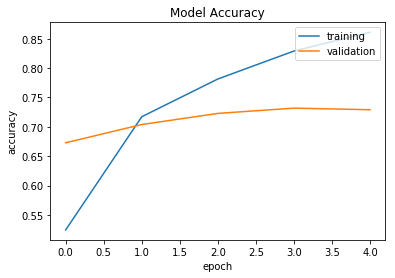

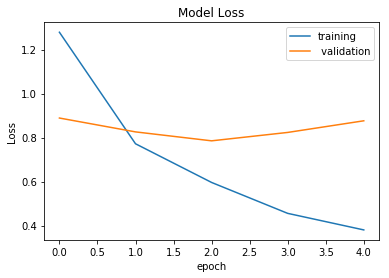

In [0]:
train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

import keras
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['training', ' validation'], loc='upper right')
plt.show()

# Upload and Test

### For use on Jupyter Notebook

In [0]:
import os
import ipywidgets as widgets
class FileBrowser(object):
    def __init__(self):
        self.path = os.getcwd()
        self._update_files()
    def _update_files(self):
        self.files = list()
        self.dirs = list()
        if(os.path.isdir(self.path)):
            for f in os.listdir(self.path):
                ff = os.path.join(self.path, f)
                if os.path.isdir(ff):
                    self.dirs.append(f)
                else:
                    self.files.append(f)
    def widget(self):
        box = widgets.VBox()
        self._update(box)
        return box
    def _update(self, box):
        def on_click(b):
            if b.description == '..':
                self.path = os.path.split(self.path)[0]
            else:
                self.path = os.path.join(self.path, b.description)
            self._update_files()
            self._update(box)
        buttons = []
        if self.files:
            button = widgets.Button(description='..', background_color='#d0d0ff')
            button.on_click(on_click)
            buttons.append(button)
        for f in self.dirs:
            button = widgets.Button(description=f, background_color='#d0d0ff')
            button.on_click(on_click)
            buttons.append(button)
        for f in self.files:
            button = widgets.Button(description=f)
            button.on_click(on_click)
            buttons.append(button)
        box.children = tuple([widgets.HTML("<h2>%s</h2>" % (self.path,))] + buttons)
f = FileBrowser()
f.widget()

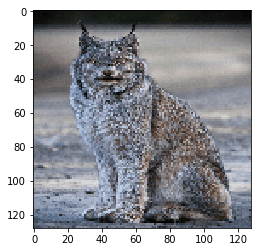

<class 'numpy.ndarray'>
lynx


In [0]:
img = image.load_img(f.path, target_size= shape )
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
imgplot = plt.imshow(img)
plt.show() 
images = np.vstack([x])
classes = VGG19_model.predict(images, batch_size=1)
index_max = np.argmax(classes)
print(f"{class_names[index_max]}")

### For use on Google Colab

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt

uploaded = files.upload()
for fn in uploaded:
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size= shape )
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  imgplot = plt.imshow(img)
  plt.show() 
  images = np.vstack([x])
  classes = VGG19_model.predict(images, batch_size=1)
  print(classes)
  index_min = np.argmin(classes)
  print(fn + f" is a {class_names[index_min]}")